In [30]:
# type:ignore
import xarray as xr
import numpy as np
import pandas as pd
import h5py
import os
import shutil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from myLibrary import convertTime, inverseLogTransform, inversTransform, image2Xarray, selectPrecipitation, logTransform

import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os

In [31]:
# Define the cropping bounds (Java Island Region) 32 x 96
lat_min, lat_max = -5.65, -8.95    # Latitude range    : 3.2° (32 pixels in 0.1°)
lon_min, lon_max = 105.15, 114.75   # Longitude range   : 9.6° (96 pixels in 0.1°)


# Define the target resolution (e.g., 0.1°)
highResDegree       = 0.1  # Change this to your desired resolution

# Define PreProcessing Method
DoPreProcessing     = True
# Define Normalized
Normalized          = True

In [32]:
DatasetsName = 'MIROC6_01'

# Path Define
# Get the absolute path 
pathNow = Path().parent.absolute() #See @Arminius answer
pathNow = pathNow.parent
print(pathNow)

# Define the base directory where MIROC6 files are stored
miroc6Dir = str(pathNow) + "/Datasets/Hasan/"

# Report Filename
DatasetsFolder = pathNow  / 'Datasets' / DatasetsName

# Create folder and delete if exists
if os.path.exists(DatasetsFolder):
    shutil.rmtree(DatasetsFolder)
os.makedirs(DatasetsFolder)

# Menggunakan tahun 2015-2024 untuk dataset MIROC6
yearTesting = np.arange(2015, 2025)  # Semua tahun tersedia (2015-2024)

# Loop through years and create filenames for MIROC6
fileTesting = [f"{miroc6Dir}ina_MIROC6_ssp245_{year}_pr.nc" for year in yearTesting]

# Define HDF5 file name
hdf5Testing = DatasetsFolder / "miroc6Testing.h5"
print(hdf5Testing)

# Verifikasi keberadaan file
print(f"\nTotal testing files: {len(fileTesting)}")
for file in fileTesting:
    if os.path.exists(file):
        print(f"  ✓ {os.path.basename(file)}")
    else:
        print(f"  ✗ {os.path.basename(file)} (NOT FOUND)")

d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code
d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01\miroc6Testing.h5

Total testing files: 10
  ✓ ina_MIROC6_ssp245_2015_pr.nc
  ✓ ina_MIROC6_ssp245_2016_pr.nc
  ✓ ina_MIROC6_ssp245_2017_pr.nc
  ✓ ina_MIROC6_ssp245_2018_pr.nc
  ✓ ina_MIROC6_ssp245_2019_pr.nc
  ✓ ina_MIROC6_ssp245_2020_pr.nc
  ✓ ina_MIROC6_ssp245_2021_pr.nc
  ✓ ina_MIROC6_ssp245_2022_pr.nc
  ✓ ina_MIROC6_ssp245_2023_pr.nc
  ✓ ina_MIROC6_ssp245_2024_pr.nc


In [33]:
# Membaca dan menggabungkan dataset MIROC6 (hanya untuk testing)
datasets = [xr.open_dataset(fp) for fp in fileTesting]
dsTesting = xr.concat(datasets, dim="time")  # Merge by time dimension

# Konversi unit dari kg m-2 s-1 ke mm/day (faktor 86400)
if 'pr' in dsTesting:
    dsTesting['pr'] = dsTesting['pr'] * 86400
    dsTesting['pr'].attrs['units'] = 'mm/day'

# Analisis struktur waktu pada dataset MIROC6 Testing
time_coord = dsTesting.coords['time']
time_info = {}

# Extract basic time information
time_info['time_units'] = time_coord.attrs.get('units', 'Not specified')
time_info['calendar'] = time_coord.attrs.get('calendar', 'Not specified')
time_info['start_date'] = pd.Timestamp(time_coord.values[0]).strftime('%Y-%m-%d %H:%M:%S')
time_info['end_date'] = pd.Timestamp(time_coord.values[-1]).strftime('%Y-%m-%d %H:%M:%S')
time_info['num_timesteps'] = len(time_coord)

# Calculate time resolution
if len(time_coord) > 1:
    time_diff = pd.Timestamp(time_coord.values[1]) - pd.Timestamp(time_coord.values[0])
    time_info['time_resolution'] = str(time_diff)
    
    # Check if time steps are regular
    time_diffs = np.array([
        (pd.Timestamp(time_coord.values[i+1]) - pd.Timestamp(time_coord.values[i])).total_seconds()
        for i in range(len(time_coord)-1)
    ])
    time_info['regular_timesteps'] = np.allclose(time_diffs, time_diffs[0])
else:
    time_info['time_resolution'] = 'Single timestep'
    time_info['regular_timesteps'] = None

# Extract all years, months, and available time periods
dates = pd.DatetimeIndex(time_coord.values)
time_info['years'] = sorted(list(set(dates.year)))
time_info['months'] = sorted(list(set(dates.month)))
time_info['days'] = sorted(list(set(dates.day)))
time_info['hours'] = sorted(list(set(dates.hour)))

print("\n===== MIROC6 Testing Dataset Time Details =====")
print(f"Time units: {time_info['time_units']}")
print(f"Calendar: {time_info['calendar']}")
print(f"Start date: {time_info['start_date']}")
print(f"End date: {time_info['end_date']}")
print(f"Number of timesteps: {time_info['num_timesteps']}")
print(f"Time resolution: {time_info['time_resolution']}")
print(f"Regular timesteps: {time_info['regular_timesteps']}")
print(f"Years available: {time_info['years']}")
print(f"Months available: {time_info['months']}")
print(f"Days available: {time_info['days']}")
print(f"Hours available: {time_info['hours']}")

# Informasi tambahan tentang dataset
print("\nTesting Dataset Shape:", dsTesting.dims)

# Periksa variabel presipitasi dan unit
precip_var = 'pr'  # Nama variabel presipitasi dalam MIROC6
if precip_var in dsTesting:
    print(f"\nPrecipitation variable: {precip_var}")
    print(f"Units: {dsTesting[precip_var].attrs.get('units', 'Unknown')}")
    
    # Tampilkan statistik dasar
    print(f"\nBasic statistics:")
    print(f"  Min: {float(dsTesting[precip_var].min()):.4f} mm/day")
    print(f"  Max: {float(dsTesting[precip_var].max()):.4f} mm/day")
    print(f"  Mean: {float(dsTesting[precip_var].mean()):.4f} mm/day")
else:
    print("\nWarning: Precipitation variable 'pr' not found in dataset!")
    print("Available variables:", list(dsTesting.data_vars))


===== MIROC6 Testing Dataset Time Details =====
Time units: Not specified
Calendar: Not specified
Start date: 2015-01-01 12:00:00
End date: 2024-12-31 12:00:00
Number of timesteps: 3653
Time resolution: 1 days 00:00:00
Regular timesteps: True
Years available: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Months available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Days available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Hours available: [12]

Testing Dataset Shape: FrozenMappingWarningOnValuesAccess({'time': 3653, 'lat': 72, 'lon': 190})

Precipitation variable: pr
Units: mm/day

Basic statistics:
  Min: 0.0000 mm/day
  Max: 187.3149 mm/day
  Mean: 7.4017 mm/day


In [34]:
precipTest      = dsTesting['pr']
print('\nTesting Datasets:')
print(dsTesting)



Testing Datasets:
<xarray.Dataset> Size: 400MB
Dimensions:  (time: 3653, lat: 72, lon: 190)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2015-01-01T12:00:00 ... 2024-12-31T12...
  * lon      (lon) float64 2kB 94.62 94.88 95.12 95.38 ... 141.4 141.6 141.9
  * lat      (lat) float64 576B -10.88 -10.62 -10.38 ... 6.375 6.625 6.875
Data variables:
    pr       (time, lat, lon) float64 400MB nan nan nan nan ... nan nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.1.1 (https://mpim...
    Conventions:           CF-1.7
    source:                BCSD
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       MIROC6
    cmip6_i

In [35]:
# Define exact number of points needed for high resolution
lat_points = 32
lon_points = 96

# Define Java region
lat_min, lat_max = -8.95, -5.65
lon_min, lon_max = 105.15, 114.75

# Print original dataset info
print("Original dataset information:")
print(f"Dimensions: {dsTesting.dims}")
print(f"Latitude range: {dsTesting.lat.min().values} to {dsTesting.lat.max().values}")
print(f"Longitude range: {dsTesting.lon.min().values} to {dsTesting.lon.max().values}")

# Crop original dataset for Java Island
print("\nCropping original dataset to Java region...")
# Determine if latitude is ascending or descending
if dsTesting.lat[0].values > dsTesting.lat[-1].values:  # Descending
    lat_slice = slice(lat_max, lat_min)  # Order matters for descending coordinates
else:  # Ascending
    lat_slice = slice(lat_min, lat_max)

# Perform the cropping
dsTesting_java = dsTesting.sel(lat=lat_slice, lon=slice(lon_min, lon_max))
print(f"Cropped original dimensions: {dsTesting_java.dims}")

# Extract precipitation variable from cropped original
precipTest = dsTesting_java['pr']
print(f"Original precipitation (Java region) shape: {precipTest.shape}")

# Create target grid coordinates directly with exactly the right number of points
target_lat = np.linspace(lat_min, lat_max, lat_points)
target_lon = np.linspace(lon_min, lon_max, lon_points)

print(f"\nCreating high-res grid with dimensions: {len(target_lat)}×{len(target_lon)}")

# Perform direct interpolation from 0.25° to target grid (0.1°)
print("Performing direct interpolation to high-res grid...")
dsHighResTest = dsTesting_java.interp(lat=target_lat, lon=target_lon, method="linear")

# Verify results
print("\nInterpolation results:")
print(f"Cropped original dimensions: {dsTesting_java.dims}")
print(f"High-res dimensions: {dsHighResTest.dims}")

# Extract precipitation variable
precipHighResTest = dsHighResTest['pr']

# Verify precipitation array shapes
print("\nPrecipitation array shapes:")
print(f"Original precipitation (Java region): {precipTest.shape}")
print(f"High-res precipitation: {precipHighResTest.shape}")

# Check if we have exactly the dimensions we need
if precipHighResTest.shape[1:] == (lat_points, lon_points):
    print("\nSUCCESS: High-res dimensions match exactly 32×96!")
else:
    print(f"\nERROR: High-res dimensions don't match. Expected (time, 32, 96), got {precipHighResTest.shape}")

# Additional verification: calculate actual resolution
original_lat_res = abs(dsTesting_java.lat[1].values - dsTesting_java.lat[0].values) if len(dsTesting_java.lat) > 1 else "N/A"
original_lon_res = abs(dsTesting_java.lon[1].values - dsTesting_java.lon[0].values) if len(dsTesting_java.lon) > 1 else "N/A"

highres_lat_res = abs(dsHighResTest.lat[1].values - dsHighResTest.lat[0].values) if len(dsHighResTest.lat) > 1 else "N/A"
highres_lon_res = abs(dsHighResTest.lon[1].values - dsHighResTest.lon[0].values) if len(dsHighResTest.lon) > 1 else "N/A"

print(f"\nResolution comparison:")
print(f"  Original: {original_lat_res}° × {original_lon_res}° (approximately 0.25°)")
print(f"  High-res: {highres_lat_res}° × {highres_lon_res}° (approximately 0.1°)")

Original dataset information:
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 3653, 'lat': 72, 'lon': 190})
Latitude range: -10.875 to 6.875
Longitude range: 94.625 to 141.875

Cropping original dataset to Java region...
Cropped original dimensions: FrozenMappingWarningOnValuesAccess({'time': 3653, 'lat': 13, 'lon': 38})
Original precipitation (Java region) shape: (3653, 13, 38)

Creating high-res grid with dimensions: 32×96
Performing direct interpolation to high-res grid...

Interpolation results:
Cropped original dimensions: FrozenMappingWarningOnValuesAccess({'time': 3653, 'lat': 13, 'lon': 38})
High-res dimensions: FrozenMappingWarningOnValuesAccess({'time': 3653, 'lat': 32, 'lon': 96})

Precipitation array shapes:
Original precipitation (Java region): (3653, 13, 38)
High-res precipitation: (3653, 32, 96)

SUCCESS: High-res dimensions match exactly 32×96!

Resolution comparison:
  Original: 0.25° × 0.25° (approximately 0.25°)
  High-res: 0.10645161290322491° × 0.1010526315

In [36]:
# Verify actual resolution achieved
if len(target_lat) > 1 and len(target_lon) > 1:
    lat_res = abs(target_lat[1] - target_lat[0])
    lon_res = abs(target_lon[1] - target_lon[0])
    print(f"\nActual resolution achieved: {lat_res:.6f}° latitude × {lon_res:.6f}° longitude")
    print(f"Target resolution was approximately 0.1°")
    
    # Calculate deviation from target
    lat_deviation = abs(lat_res - 0.1) / 0.1 * 100
    lon_deviation = abs(lon_res - 0.1) / 0.1 * 100
    print(f"Deviation from target: {lat_deviation:.2f}% (lat), {lon_deviation:.2f}% (lon)")


Actual resolution achieved: 0.106452° latitude × 0.101053° longitude
Target resolution was approximately 0.1°
Deviation from target: 6.45% (lat), 1.05% (lon)


In [37]:
# Handle NaN values in precipitation data
print('Handling NaN values in precipitation data')

# Extract precipitation variables if not already done
if 'precipTest' not in locals():
    precipTest = dsTesting['pr']
if 'precipHighResTest' not in locals():
    precipHighResTest = dsHighResTest['pr']

# Check for NaN values before replacement
original_nan_count = np.isnan(precipTest.values).sum()
highres_nan_count = np.isnan(precipHighResTest.values).sum()

original_nan_percent = original_nan_count / precipTest.size * 100
highres_nan_percent = highres_nan_count / precipHighResTest.size * 100

print(f"NaN statistics before handling:")
print(f"  Original data: {original_nan_count} NaN values ({original_nan_percent:.2f}%)")
print(f"  High-res data: {highres_nan_count} NaN values ({highres_nan_percent:.2f}%)")

# Replace NaN with 0 in xarray DataArrays
print("Replacing NaN values with 0...")
precipTest = precipTest.fillna(0)
precipHighResTest = precipHighResTest.fillna(0)

# Verify replacement
zero_count_test = (precipTest.values == 0).sum()
zero_count_highres = (precipHighResTest.values == 0).sum()

print(f"Zero values after NaN replacement:")
print(f"  Original data: {zero_count_test} zero values ({zero_count_test / precipTest.size * 100:.2f}%)")
print(f"  High-res data: {zero_count_highres} zero values ({zero_count_highres / precipHighResTest.size * 100:.2f}%)")

# Verify all NaN values are replaced
remaining_nan_test = np.isnan(precipTest.values).sum()
remaining_nan_highres = np.isnan(precipHighResTest.values).sum()

if remaining_nan_test == 0 and remaining_nan_highres == 0:
    print("SUCCESS: All NaN values have been replaced with 0.")
else:
    print(f"WARNING: Some NaN values remain! Test: {remaining_nan_test}, High-res: {remaining_nan_highres}")

# Value ranges after NaN replacement
print(f"\nValue ranges after NaN replacement:")
print(f"  Original data: min={float(precipTest.min()):.4f}, max={float(precipTest.max()):.4f}")
print(f"  High-res data: min={float(precipHighResTest.min()):.4f}, max={float(precipHighResTest.max()):.4f}")


Handling NaN values in precipitation data
NaN statistics before handling:
  Original data: 869414 NaN values (48.18%)
  High-res data: 7368101 NaN values (65.66%)
Replacing NaN values with 0...
Zero values after NaN replacement:
  Original data: 1017786 zero values (56.40%)
  High-res data: 7936502 zero values (70.72%)
SUCCESS: All NaN values have been replaced with 0.

Value ranges after NaN replacement:
  Original data: min=0.0000, max=120.8447
  High-res data: min=0.0000, max=113.9028


In [38]:
# Log Transformation untuk dataset MIROC6
if DoPreProcessing:
    print('Performing PreProcessing')
    
    # Apply log transformation with epsilon
    precipTest = logTransform(precipTest)
    precipHighResTest = logTransform(precipHighResTest)
    
    print(f"Log transformation applied:")
    print(f"  Original data shape: {precipTest.shape}")
    print(f"  High-res data shape: {precipHighResTest.shape}")
    
    # Optional: verify value ranges after transformation
    print(f"\nValue ranges after log transformation:")
    print(f"  Original data: min={float(precipTest.min()):.4f}, max={float(precipTest.max()):.4f}")
    print(f"  High-res data: min={float(precipHighResTest.min()):.4f}, max={float(precipHighResTest.max()):.4f}")

Performing PreProcessing
Log transformation applied:
  Original data shape: (3653, 13, 38)
  High-res data shape: (3653, 32, 96)

Value ranges after log transformation:
  Original data: min=0.0953, max=4.8036
  High-res data: min=0.0953, max=4.7450


In [39]:
if Normalized:
    print('Performing Data Normalization')
    # Apply Scaler (fit on available data)
    scaler = MinMaxScaler()
    
    # Untuk konsistensi dengan model yang telah dilatih, idealnya kita menggunakan
    # statistik/parameter yang sama dari data training
    # Namun, karena kita hanya memiliki data testing, kita fit scaler pada data testing
    
    # Flatten data untuk fitting scaler
    flattened_test_data = precipTest.values.reshape(-1, 1)
    
    # Fit dan transform data precipTest
    scaledTesting = scaler.fit_transform(flattened_test_data)
    
    # Transform data high-res menggunakan scaler yang sama
    scaledHighResTest = scaler.transform(precipHighResTest.values.reshape(-1, 1))
    
    # Simpan parameter scaler untuk dokumentasi
    min_val = scaler.data_min_[0]
    max_val = scaler.data_max_[0]
    print(f"Normalization parameters:")
    print(f"  Min value: {min_val:.4f}")
    print(f"  Max value: {max_val:.4f}")
    
    # Reshape back to original shape
    precipTest = scaledTesting.reshape(precipTest.shape)
    precipHighResTest = scaledHighResTest.reshape(precipHighResTest.shape)
    
    # Verifikasi range setelah normalisasi
    print(f"Value ranges after normalization:")
    print(f"  Original data: min={float(np.min(precipTest)):.4f}, max={float(np.max(precipTest)):.4f}")
    print(f"  High-res data: min={float(np.min(precipHighResTest)):.4f}, max={float(np.max(precipHighResTest)):.4f}")

Performing Data Normalization
Normalization parameters:
  Min value: 0.0953
  Max value: 4.8036
Value ranges after normalization:
  Original data: min=0.0000, max=1.0000
  High-res data: min=0.0000, max=0.9876


In [40]:
print(scaler)

MinMaxScaler()


In [41]:
# Reshape for CNN input format (TensorFlow format: [Samples, Height, Width, Channels])
print("\nReshaping data for CNN input format...")

# Check current data type
print(f"Current data types:")
print(f"  precipTest type: {type(precipTest)}")
print(f"  precipHighResTest type: {type(precipHighResTest)}")

# Reshape by adding channel dimension
precipTest = np.expand_dims(precipTest, axis=-1)  # Shape: [T, H, W, 1]
precipHighResTest = np.expand_dims(precipHighResTest, axis=-1)  # Shape: [T, H, W, 1]

# Handle any remaining NaN values
precipTest = np.nan_to_num(precipTest, nan=0)
precipHighResTest = np.nan_to_num(precipHighResTest, nan=0)

# Verify shapes and data characteristics
print(f"CNN input shapes:")
print(f"  Original data: {precipTest.shape}")
print(f"  High-res data: {precipHighResTest.shape}")

# Verify no NaN values remain
test_nan_count = np.isnan(precipTest).sum()
highres_nan_count = np.isnan(precipHighResTest).sum()
print(f"\nRemaining NaN values:")
print(f"  Original data: {test_nan_count}")
print(f"  High-res data: {highres_nan_count}")

# Verify value ranges
print(f"\nValue ranges after reshape:")
print(f"  Original data: min={np.min(precipTest):.4f}, max={np.max(precipTest):.4f}")
print(f"  High-res data: min={np.min(precipHighResTest):.4f}, max={np.max(precipHighResTest):.4f}")

print("\nData preprocessing complete, ready for model input!")


Reshaping data for CNN input format...
Current data types:
  precipTest type: <class 'numpy.ndarray'>
  precipHighResTest type: <class 'numpy.ndarray'>
CNN input shapes:
  Original data: (3653, 13, 38, 1)
  High-res data: (3653, 32, 96, 1)

Remaining NaN values:
  Original data: 0
  High-res data: 0

Value ranges after reshape:
  Original data: min=0.0000, max=1.0000
  High-res data: min=0.0000, max=0.9876

Data preprocessing complete, ready for model input!


In [42]:
# Ambil koordinat dan time dari dataset
# Jika variable ini masih dalam format xarray, ambil values nya terlebih dahulu
latOriginal = dsTesting_java.lat.values if hasattr(dsTesting_java, 'lat') else dsTesting_java.lat
lonOriginal = dsTesting_java.lon.values if hasattr(dsTesting_java, 'lon') else dsTesting_java.lon

# Ambil koordinat untuk dataset high-res
latHighRes = dsHighResTest.lat.values if hasattr(dsHighResTest, 'lat') else dsHighResTest.lat
lonHighRes = dsHighResTest.lon.values if hasattr(dsHighResTest, 'lon') else dsHighResTest.lon

# Penanganan waktu
# Jika fungsi convertTime belum didefinisikan, gunakan fungsi sederhana berikut
if 'convertTime' not in globals():
    def convertTime(time_array):
        """Convert numpy datetime64 array to seconds since epoch for HDF5 compatibility"""
        # Convert to seconds since epoch if it's datetime64
        if np.issubdtype(time_array.dtype, np.datetime64):
            return (time_array - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
        return time_array

# Ambil waktu dari dataset
timeOriginalTest = dsTesting_java.time.values if hasattr(dsTesting_java, 'time') else dsTesting_java.time
timeHighResTest = dsHighResTest.time.values if hasattr(dsHighResTest, 'time') else dsHighResTest.time

# Definisikan file HDF5 untuk testing
hdf5Testing = DatasetsFolder / "miroc6Testing.h5"

print(f"Saving data to HDF5 file: {hdf5Testing}")
try:
    with h5py.File(hdf5Testing, "w") as hf:
        # Simpan data presipitasi
        hf.create_dataset("precipTestOriginal", data=precipTest, compression="gzip")
        hf.create_dataset("precipHighResTest", data=precipHighResTest, compression="gzip")
        
        # Simpan koordinat
        hf.create_dataset("latOriginal", data=latOriginal, compression="gzip")
        hf.create_dataset("lonOriginal", data=lonOriginal, compression="gzip")
        hf.create_dataset("latHighRes", data=latHighRes, compression="gzip")
        hf.create_dataset("lonHighRes", data=lonHighRes, compression="gzip")
        
        # Simpan waktu
        hf.create_dataset("timeOriginalTest", data=convertTime(timeOriginalTest), compression="gzip") 
        hf.create_dataset("timeHighResTest", data=convertTime(timeHighResTest), compression="gzip")
        
        # Simpan metadata tambahan
        # Tentang dataset dan preprocessing
        hf.attrs['dataset_source'] = 'MIROC6'
        hf.attrs['dataset_scenario'] = 'ssp245'
        hf.attrs['region'] = 'Java Island'
        hf.attrs['original_resolution'] = '0.25 degrees'
        hf.attrs['highres_resolution'] = '0.1 degrees'
        hf.attrs['preprocessing_date'] = str(np.datetime64('now'))
        
        # Jika normalisasi dilakukan
        if 'Normalized' in globals() and Normalized and 'scaler' in globals():
            hf.create_dataset("scale_", data=scaler.scale_)
            hf.create_dataset("min_", data=scaler.min_)
            hf.create_dataset("data_min_", data=scaler.data_min_)
            hf.create_dataset("data_max_", data=scaler.data_max_)
            hf.create_dataset("feature_range", data=np.array(scaler.feature_range))
            hf.attrs['normalization'] = 'MinMaxScaler'
        
        # Jika preprocessing dilakukan
        if 'DoPreProcessing' in globals() and DoPreProcessing:
            hf.attrs['log_transform'] = 'Applied'
    
    print(f"Dataset successfully saved: {hdf5Testing}")
    
    # Tampilkan informasi file
    print("\nSaved datasets:")
    with h5py.File(hdf5Testing, "r") as hf:
        print(f"HDF5 file contents:")
        for key in hf.keys():
            print(f"  - {key}: {hf[key].shape}, {hf[key].dtype}")
        print("\nAttributes:")
        for key, value in hf.attrs.items():
            print(f"  - {key}: {value}")

except Exception as e:
    print(f"Error saving HDF5 file: {e}")

Saving data to HDF5 file: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01\miroc6Testing.h5
Dataset successfully saved: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01\miroc6Testing.h5

Saved datasets:
HDF5 file contents:
  - data_max_: (1,), float64
  - data_min_: (1,), float64
  - feature_range: (2,), int32
  - latHighRes: (32,), float64
  - latOriginal: (13,), float64
  - lonHighRes: (96,), float64
  - lonOriginal: (38,), float64
  - min_: (1,), float64
  - precipHighResTest: (3653, 32, 96, 1), float64
  - precipTestOriginal: (3653, 13, 38, 1), float64
  - scale_: (1,), float64
  - timeHighResTest: (3653,), int64
  - timeOriginalTest: (3653,), int64

Attributes:
  - dataset_scenario: ssp245
  - dataset_source: MIROC6
  - highres_resolution: 0.1 degrees
  - log_transform: Applied
  - normalization: MinMaxScaler
  - original_resolution: 0.25 degrees
  - preprocessing_date: 2025-0

In [43]:
# Define path to HDF5 file
hdf5Testing = DatasetsFolder / "miroc6Testing.h5"

# Check if file exists before loading
if not os.path.exists(hdf5Testing):
    print(f"Error: File {hdf5Testing} does not exist.")
else:
    print(f"Loading dataset from: {hdf5Testing}")
    
    try:
        # Load dataset from HDF5
        with h5py.File(hdf5Testing, "r") as hf:
            # Print available datasets in the file
            print("Available datasets in the HDF5 file:")
            for key in hf.keys():
                print(f"  - {key}")
            
            # Load precipitation data
            precipTestOriginal = hf["precipTestOriginal"][:]
            precipHighResTest = hf["precipHighResTest"][:]
            
            # Check if low-res data exists and load if available
            if "precipLowResTest" in hf:
                precipLowResTest = hf["precipLowResTest"][:]
                print("Low-res data loaded successfully.")
            else:
                print("Note: Low-res data not found in the file.")
            
            # Load time information
            timeOriginalTest = hf["timeOriginalTest"][:]
            timeHighResTest = hf["timeHighResTest"][:]
            
            # Load coordinates
            latOriginal = hf["latOriginal"][:]
            lonOriginal = hf["lonOriginal"][:]
            latHighRes = hf["latHighRes"][:]
            lonHighRes = hf["lonHighRes"][:]
            
            # Load normalization parameters if available
            if "scale_" in hf and "Normalized" in globals() and Normalized:
                scale_ = hf["scale_"][:]
                min_ = hf["min_"][:]
                data_min_ = hf["data_min_"][:]
                data_max_ = hf["data_max_"][:]
                feature_range = hf["feature_range"][:]
                
                # Optional: Reconstruct the scaler (if needed)
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                scaler.scale_ = scale_
                scaler.min_ = min_
                scaler.data_min_ = data_min_
                scaler.data_max_ = data_max_
                scaler.feature_range = tuple(feature_range)
                
                print("Normalization parameters loaded successfully.")
            
            print("\nLoaded data shapes:")
            print(f"  Original Test Data: {precipTestOriginal.shape}")
            if 'precipLowResTest' in locals():
                print(f"  Low-res Test Data: {precipLowResTest.shape}")
            print(f"  High-res Test Data: {precipHighResTest.shape}")
            
            # Convert time to human-readable format for verification
            print("\nTime range:")
            time_start = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(int(timeOriginalTest[0]), 's')
            time_end = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(int(timeOriginalTest[-1]), 's')
            print(f"  Start: {time_start}")
            print(f"  End: {time_end}")
            print(f"  Total timesteps: {len(timeOriginalTest)}")
            
            # Print coordinate information
            print("\nCoordinate information:")
            print(f"  Original latitude range: {latOriginal.min():.4f} to {latOriginal.max():.4f}, points: {len(latOriginal)}")
            print(f"  Original longitude range: {lonOriginal.min():.4f} to {lonOriginal.max():.4f}, points: {len(lonOriginal)}")
            print(f"  High-res latitude range: {latHighRes.min():.4f} to {latHighRes.max():.4f}, points: {len(latHighRes)}")
            print(f"  High-res longitude range: {lonHighRes.min():.4f} to {lonHighRes.max():.4f}, points: {len(lonHighRes)}")
            
            # Check for any additional metadata
            if len(hf.attrs) > 0:
                print("\nFile metadata:")
                for key, value in hf.attrs.items():
                    print(f"  {key}: {value}")
            
            print("\nData loaded successfully.")
            
    except Exception as e:
        print(f"Error loading HDF5 file: {e}")

Loading dataset from: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01\miroc6Testing.h5
Available datasets in the HDF5 file:
  - data_max_
  - data_min_
  - feature_range
  - latHighRes
  - latOriginal
  - lonHighRes
  - lonOriginal
  - min_
  - precipHighResTest
  - precipTestOriginal
  - scale_
  - timeHighResTest
  - timeOriginalTest
Note: Low-res data not found in the file.
Normalization parameters loaded successfully.

Loaded data shapes:
  Original Test Data: (3653, 13, 38, 1)
  High-res Test Data: (3653, 32, 96, 1)

Time range:
  Start: 45001610490-05-14T00:00:00
  End: 55000446879-11-21T00:00:00
  Total timesteps: 3653

Coordinate information:
  Original latitude range: -8.8750 to -5.8750, points: 13
  Original longitude range: 105.3750 to 114.6250, points: 38
  High-res latitude range: -8.9500 to -5.6500, points: 32
  High-res longitude range: 105.1500 to 114.7500, points: 96

File metadata:
  dataset_scenario: ssp245
  data

In [44]:
# Invers to original precipitation data
if Normalized:
    # Recreate Min Max Scaler with saved parameters
    print('Invers to original precipitation data using Min Max Scaler')
    scaler = MinMaxScaler()
    scaler.scale_ = scale_ 
    scaler.min_ = min_
    scaler.data_min_ = data_min_
    scaler.data_max_ = data_max_
    scaler.feature_range = tuple(feature_range)  # Convert to tuple if it's an array
    
    # Apply inverse transform only on testing data that we have
    precipTestOriginal = inversTransform(scaler, precipTestOriginal)
    
    if 'precipLowResTest' in locals():
        precipLowResTest = inversTransform(scaler, precipLowResTest)
        
    precipHighResTest = inversTransform(scaler, precipHighResTest)
    
    print("Normalization successfully inverted.")

# Invers to original precipitation data - log transformation
if DoPreProcessing:
    print('Invers to original precipitation data using Log Transformation')
    
    # Apply inverse log transform only on testing data that we have
    precipTestOriginal = inverseLogTransform(precipTestOriginal)
    
    if 'precipLowResTest' in locals():
        precipLowResTest = inverseLogTransform(precipLowResTest)
        
    precipHighResTest = inverseLogTransform(precipHighResTest)
    
    print("Log transformation successfully inverted.")

# Verify the value ranges after inverse transformations
print("\nValue ranges after inverse transforms:")
print(f"  Original data: min={np.min(precipTestOriginal):.4f}, max={np.max(precipTestOriginal):.4f}")
if 'precipLowResTest' in locals():
    print(f"  Low-res data: min={np.min(precipLowResTest):.4f}, max={np.max(precipLowResTest):.4f}")
print(f"  High-res data: min={np.min(precipHighResTest):.4f}, max={np.max(precipHighResTest):.4f}")

# Check for any NaN values after inverse transforms
test_nan = np.isnan(precipTestOriginal).sum()
highres_nan = np.isnan(precipHighResTest).sum()
lowres_nan = np.isnan(precipLowResTest).sum() if 'precipLowResTest' in locals() else 0

if test_nan > 0 or highres_nan > 0 or lowres_nan > 0:
    print("\nWarning: NaN values found after inverse transforms:")
    print(f"  Original data: {test_nan} NaN values")
    if 'precipLowResTest' in locals():
        print(f"  Low-res data: {lowres_nan} NaN values")
    print(f"  High-res data: {highres_nan} NaN values")
else:
    print("\nNo NaN values found after inverse transforms.")

print("\nData is now in its original scale (mm/day).")

Invers to original precipitation data using Min Max Scaler
Normalization successfully inverted.
Invers to original precipitation data using Log Transformation
Log transformation successfully inverted.

Value ranges after inverse transforms:
  Original data: min=0.0000, max=120.8447
  High-res data: min=0.0000, max=113.9028

No NaN values found after inverse transforms.

Data is now in its original scale (mm/day).


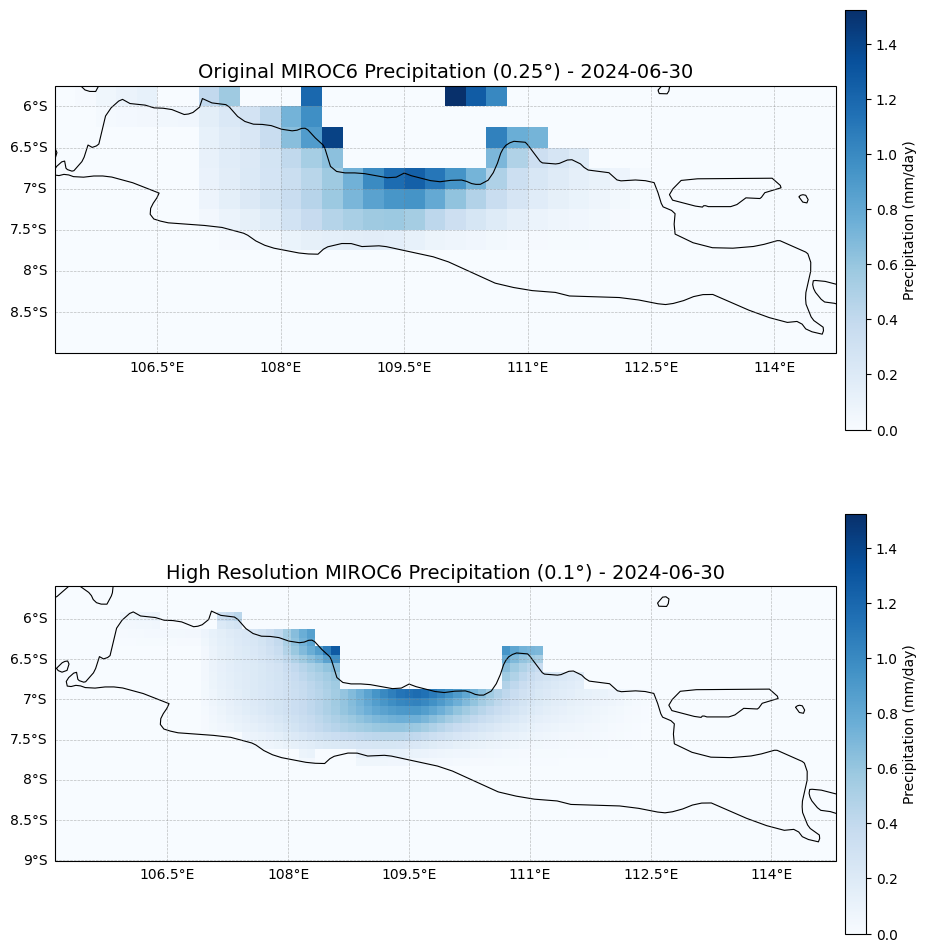

In [45]:
def plot_miroc6_comparison_single(date_str):
    """
    Plot MIROC6 precipitation comparison (original and high-res) in a single figure.
    
    Parameters:
    -----------
    date_str : str
        Date string in 'YYYY-MM-DD' format.
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np
    from datetime import datetime
    import pandas as pd
    
    # Convert time values to datetime silently
    datetime_timestamps = [pd.Timestamp(t) for t in timeOriginalTest]
    
    # Parse the requested date
    requested_date = datetime.strptime(date_str, '%Y-%m-%d')
    
    # Find closest date
    date_diffs = [(abs((date.to_pydatetime() - requested_date).total_seconds()), i) 
                 for i, date in enumerate(datetime_timestamps)]
    _, time_idx = min(date_diffs)
    selected_date = datetime_timestamps[time_idx].to_pydatetime()
    
    # Get formatted date string
    date_str_formatted = selected_date.strftime('%Y-%m-%d')
    
    # Create datasets
    dsOriginalTest = image2Xarray(precipTestOriginal[:,:,:,0], lonOriginal, latOriginal, timeOriginalTest)
    dsHighResTest = image2Xarray(precipHighResTest[:,:,:,0], lonHighRes, latHighRes, timeHighResTest)
    
    # Extract data for the selected date
    precipOriginal = dsOriginalTest['precipitation'].isel(time=time_idx)
    precipHighRes = dsHighResTest['precipitation'].isel(time=time_idx)
    
    # Create figure with 2 subplots vertically stacked
    fig, axs = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set common colormap range for both plots
    vmin = min(float(precipOriginal.min()), float(precipHighRes.min()))
    vmax = max(float(precipOriginal.max()), float(precipHighRes.max()))
    if vmax - vmin < 0.01:
        vmin, vmax = 0, 1
    
    # Plot original data (top)
    im1 = precipOriginal.plot(ax=axs[0], cmap='Blues', transform=ccrs.PlateCarree(), 
                           vmin=vmin, vmax=vmax, add_colorbar=False)
    cbar1 = plt.colorbar(im1, ax=axs[0], orientation='vertical', pad=0.01, 
                        label='Precipitation (mm/day)')
    cbar1.ax.tick_params(labelsize=10)
    
    axs[0].coastlines(resolution='50m', linewidth=0.8)
    axs[0].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
    gl1 = axs[0].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    axs[0].set_title(f"Original MIROC6 Precipitation (0.25°) - {date_str_formatted}", fontsize=14)
    
    # Plot high-res data (bottom)
    im2 = precipHighRes.plot(ax=axs[1], cmap='Blues', transform=ccrs.PlateCarree(),
                           vmin=vmin, vmax=vmax, add_colorbar=False)
    cbar2 = plt.colorbar(im2, ax=axs[1], orientation='vertical', pad=0.01, 
                        label='Precipitation (mm/day)')
    cbar2.ax.tick_params(labelsize=10)
    
    axs[1].coastlines(resolution='50m', linewidth=0.8)
    axs[1].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
    gl2 = axs[1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl2.top_labels = False
    gl2.right_labels = False
    axs[1].set_title(f"High Resolution MIROC6 Precipitation (0.1°) - {date_str_formatted}", fontsize=14)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.2)
    
    # Save figure with high quality
    filename = f"{DatasetsFolder}/MIROC6_comparison_{date_str_formatted}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    return fig, axs

# Example usage - call with your desired date
selected_date = '2024-07-01'  # Change to your preferred date
fig, axs = plot_miroc6_comparison_single(selected_date)

In [46]:
# Define path to HDF5 file
hdf5Testing = DatasetsFolder / "miroc6Testing.h5"

# Check if file exists before loading
if not os.path.exists(hdf5Testing):
    print(f"Error: File {hdf5Testing} does not exist.")
else:
    print(f"Loading dataset from: {hdf5Testing}")
    
    try:
        # Load dataset from HDF5
        with h5py.File(hdf5Testing, "r") as hf:
            # Print available datasets in the file
            print("Available datasets in the HDF5 file:")
            for key in hf.keys():
                print(f"  - {key}")
            
            # Load precipitation data
            precipTestOriginal = hf["precipTestOriginal"][:]
            precipHighResTest = hf["precipHighResTest"][:]
            
            # Check if low-res data exists and load if available
            if "precipLowResTest" in hf:
                precipLowResTest = hf["precipLowResTest"][:]
                print("Low-res data loaded successfully.")
            else:
                print("Note: Low-res data not found in the file.")
            
            # Load time information
            timeOriginalTest = hf["timeOriginalTest"][:]
            timeHighResTest = hf["timeHighResTest"][:]
            
            # Load coordinates
            latOriginal = hf["latOriginal"][:]
            lonOriginal = hf["lonOriginal"][:]
            latHighRes = hf["latHighRes"][:]
            lonHighRes = hf["lonHighRes"][:]
            
            # Load normalization parameters if available
            if "scale_" in hf and "Normalized" in globals() and Normalized:
                scale_ = hf["scale_"][:]
                min_ = hf["min_"][:]
                data_min_ = hf["data_min_"][:]
                data_max_ = hf["data_max_"][:]
                feature_range = hf["feature_range"][:]
                
                # Optional: Reconstruct the scaler (if needed)
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                scaler.scale_ = scale_
                scaler.min_ = min_
                scaler.data_min_ = data_min_
                scaler.data_max_ = data_max_
                scaler.feature_range = tuple(feature_range)
                
                print("Normalization parameters loaded successfully.")
            
            print("\nLoaded data shapes:")
            print(f"  Original Test Data: {precipTestOriginal.shape}")
            if 'precipLowResTest' in locals():
                print(f"  Low-res Test Data: {precipLowResTest.shape}")
            print(f"  High-res Test Data: {precipHighResTest.shape}")
            
            # Convert time to human-readable format for verification
            print("\nTime range:")
            time_start = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(int(timeOriginalTest[0]), 's')
            time_end = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(int(timeOriginalTest[-1]), 's')
            print(f"  Start: {time_start}")
            print(f"  End: {time_end}")
            print(f"  Total timesteps: {len(timeOriginalTest)}")
            
            # Print coordinate information
            print("\nCoordinate information:")
            print(f"  Original latitude range: {latOriginal.min():.4f} to {latOriginal.max():.4f}, points: {len(latOriginal)}")
            print(f"  Original longitude range: {lonOriginal.min():.4f} to {lonOriginal.max():.4f}, points: {len(lonOriginal)}")
            print(f"  High-res latitude range: {latHighRes.min():.4f} to {latHighRes.max():.4f}, points: {len(latHighRes)}")
            print(f"  High-res longitude range: {lonHighRes.min():.4f} to {lonHighRes.max():.4f}, points: {len(lonHighRes)}")
            
            # Check for any additional metadata
            if len(hf.attrs) > 0:
                print("\nFile metadata:")
                for key, value in hf.attrs.items():
                    print(f"  {key}: {value}")
            
            print("\nData loaded successfully.")
            
    except Exception as e:
        print(f"Error loading HDF5 file: {e}")

Loading dataset from: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01\miroc6Testing.h5
Available datasets in the HDF5 file:
  - data_max_
  - data_min_
  - feature_range
  - latHighRes
  - latOriginal
  - lonHighRes
  - lonOriginal
  - min_
  - precipHighResTest
  - precipTestOriginal
  - scale_
  - timeHighResTest
  - timeOriginalTest
Note: Low-res data not found in the file.
Normalization parameters loaded successfully.

Loaded data shapes:
  Original Test Data: (3653, 13, 38, 1)
  High-res Test Data: (3653, 32, 96, 1)

Time range:
  Start: 45001610490-05-14T00:00:00
  End: 55000446879-11-21T00:00:00
  Total timesteps: 3653

Coordinate information:
  Original latitude range: -8.8750 to -5.8750, points: 13
  Original longitude range: 105.3750 to 114.6250, points: 38
  High-res latitude range: -8.9500 to -5.6500, points: 32
  High-res longitude range: 105.1500 to 114.7500, points: 96

File metadata:
  dataset_scenario: ssp245
  data

In [47]:
print(np.max(precipHighResTest))
print(np.max(precipTestOriginal))

0.9875514082736531
0.9999999999999999


In [48]:
print(precipHighResTest.shape)

(3653, 32, 96, 1)


In [49]:
# Step 1: Import library yang diperlukan
# Step 2: Definisikan path ke model .keras Anda
# Gunakan Path untuk penanganan path yang konsisten di berbagai sistem operasi
model_path = str(pathNow / "Reports" / "GAN_JI_LT_N_04_01_1kEpoch" / "generator_final.keras")
print(f"Model path: {model_path}")

# Step 3: Periksa keberadaan file model
if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
else:
    print(f"Model file found at {model_path}")

# Step 4: Load model
print("Loading model...")
try:
    # Load model .keras (TensorFlow 2.x style)
    generator = load_model(model_path, compile=False)
    print("Model loaded successfully!")
    
    # Tampilkan summary model
    generator.summary()
except Exception as e:
    print(f"Error loading model: {e}")

Model path: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Reports\GAN_JI_LT_N_04_01_1kEpoch\generator_final.keras
Model file found at d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Reports\GAN_JI_LT_N_04_01_1kEpoch\generator_final.keras
Loading model...
Model loaded successfully!
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 96, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 48, 64)   1088        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (

In [50]:
# Step 5: Persiapkan data input (precipHighResTest sebagai input)
print("Preparing input data...")

# Verifikasi shape data input
print(f"Input data shape: {precipHighResTest.shape}")

# Step 6: Periksa dan pastikan format data input sesuai
# Model biasanya mengharapkan format [batch, height, width, channels]
if len(precipHighResTest.shape) != 4:
    print("Reshaping input data to add channel dimension...")
    input_data = np.expand_dims(precipHighResTest, axis=-1)
else:
    input_data = precipHighResTest

print(f"Final input shape: {input_data.shape}")

Preparing input data...
Input data shape: (3653, 32, 96, 1)
Final input shape: (3653, 32, 96, 1)


In [51]:
# Step 7: Jalankan prediksi dengan model
print("Running predictions...")
try:
    # Lakukan prediksi batch-by-batch jika data terlalu besar
    batch_size = 32  # Sesuaikan dengan memori yang tersedia
    n_samples = input_data.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    # Inisialisasi array untuk menyimpan hasil
    # Asumsikan output model memiliki shape yang sama dengan input
    output_shape = input_data.shape
    generated_data = np.zeros(output_shape)
    
    print(f"Expected output shape: {output_shape}")
    print(f"Processing {n_samples} samples in {n_batches} batches...")
    
    # Proses batch-by-batch
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        print(f"Processing batch {i+1}/{n_batches} (samples {start_idx} to {end_idx-1})...")
        batch_input = input_data[start_idx:end_idx]
        
        # Prediksi batch
        batch_output = generator.predict(batch_input)
        
        # Simpan hasil ke array output
        generated_data[start_idx:end_idx] = batch_output
    
    print("Predictions completed successfully!")
    print(f"Generated data shape: {generated_data.shape}")
    
except Exception as e:
    print(f"Error during prediction: {e}")

Running predictions...
Expected output shape: (3653, 32, 96, 1)
Processing 3653 samples in 115 batches...
Processing batch 1/115 (samples 0 to 31)...
1/1 [==============================] - 0s 158ms/step
Processing batch 2/115 (samples 32 to 63)...
1/1 [==============================] - 0s 18ms/step
Processing batch 3/115 (samples 64 to 95)...
1/1 [==============================] - 0s 30ms/step
Processing batch 4/115 (samples 96 to 127)...
1/1 [==============================] - 0s 27ms/step
Processing batch 5/115 (samples 128 to 159)...
1/1 [==============================] - 0s 16ms/step
Processing batch 6/115 (samples 160 to 191)...
1/1 [==============================] - 0s 20ms/step
Processing batch 7/115 (samples 192 to 223)...
1/1 [==============================] - 0s 18ms/step
Processing batch 8/115 (samples 224 to 255)...
1/1 [==============================] - 0s 21ms/step
Processing batch 9/115 (samples 256 to 287)...
1/1 [==============================] - 0s 42ms/step
Processing

In [52]:
# Step 8: Simpan hasil prediksi
output_file = f"{DatasetsFolder}/MIROC6_GAN_output.npy"
try:
    np.save(output_file, generated_data)
    print(f"Generated data saved to {output_file}")
except Exception as e:
    print(f"Error saving output: {e}")

# Step 9: Tambahkan hasil ke variabel global untuk penggunaan selanjutnya
precipGeneratedTest = generated_data
print("Variable 'precipGeneratedTest' created with generated data.")

# Step 10: Cetak statistik dasar untuk verifikasi hasil
print("\nBasic statistics:")
print(f"  Input min: {np.min(input_data):.4f}, max: {np.max(input_data):.4f}, mean: {np.mean(input_data):.4f}")
print(f"  Output min: {np.min(generated_data):.4f}, max: {np.max(generated_data):.4f}, mean: {np.mean(generated_data):.4f}")

# Step 11: Simpan hasil sebagai xarray dataset jika diperlukan
try:
    # Buat dataset xarray menggunakan image2Xarray untuk mempertahankan koordinat
    # Hilangkan dimensi channel dengan [:,:,:,0]
    dsGeneratedTest = image2Xarray(
        generated_data[:,:,:,0], 
        lonHighRes, 
        latHighRes, 
        timeOriginalTest
    )
    
    # Simpan sebagai NetCDF
    netcdf_output = f"{DatasetsFolder}/MIROC6_GAN_output.nc"
    dsGeneratedTest.to_netcdf(netcdf_output)
    print(f"Generated data saved as NetCDF: {netcdf_output}")
except Exception as e:
    print(f"Error saving as xarray/NetCDF: {e}")

Generated data saved to d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01/MIROC6_GAN_output.npy
Variable 'precipGeneratedTest' created with generated data.

Basic statistics:
  Input min: 0.0000, max: 0.9876, mean: 0.1073
  Output min: 0.0000, max: 0.9997, mean: 0.0324
Generated data saved as NetCDF: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\MIROC6_01/MIROC6_GAN_output.nc


In [53]:
# Step 1: Lakukan inverse preprocessing pada hasil generate dari GAN dan data high-res
# Invers to original precipitation data - normalization
if Normalized:
    # Recreate Min Max Scaler with saved parameters
    print('Inverse to original precipitation data using Min Max Scaler')
    scaler = MinMaxScaler()
    scaler.scale_ = scale_ 
    scaler.min_ = min_
    scaler.data_min_ = data_min_
    scaler.data_max_ = data_max_
    scaler.feature_range = tuple(feature_range)  # Convert to tuple if it's an array
    
    # Apply inverse transform to both high-res and GAN output data
    print("Applying inverse normalization to high-res data...")
    precipHighResTest = inversTransform(scaler, precipHighResTest)
    
    print("Applying inverse normalization to GAN output data...")
    precipGeneratedTest = inversTransform(scaler, precipGeneratedTest)
    precipTestOriginal = inversTransform(scaler, precipTestOriginal)
    
    print("Normalization successfully inverted for both datasets.")

# Invers to original precipitation data - log transformation
if DoPreProcessing:
    print('Inverse to original precipitation data using Log Transformation')
    
    # Apply inverse log transform to both datasets
    print("Applying inverse log transform to high-res data...")
    precipHighResTest = inverseLogTransform(precipHighResTest)
    
    print("Applying inverse log transform to GAN output...")
    precipGeneratedTest = inverseLogTransform(precipGeneratedTest)
    precipTestOriginal = inverseLogTransform(precipTestOriginal)
    
    print("Log transformation successfully inverted for both datasets.")

# Verify the value ranges after inverse transformations
print("\nValue ranges after inverse transforms:")
print(f"  High-res data: min={np.min(precipHighResTest):.4f}, max={np.max(precipHighResTest):.4f}, mean={np.mean(precipHighResTest):.4f}")
print(f"  Generated data: min={np.min(precipGeneratedTest):.4f}, max={np.max(precipGeneratedTest):.4f}, mean={np.mean(precipGeneratedTest):.4f}")

# Check for any NaN values
highres_nan = np.isnan(precipHighResTest).sum()
generated_nan = np.isnan(precipGeneratedTest).sum()

if highres_nan > 0 or generated_nan > 0:
    print("\nWarning: NaN values found after inverse transforms:")
    print(f"  High-res data: {highres_nan} NaN values")
    print(f"  Generated data: {generated_nan} NaN values")
    
    # Replace NaN values with zeros if needed
    if highres_nan > 0:
        print("Replacing NaN values in high-res data with zeros...")
        precipHighResTest = np.nan_to_num(precipHighResTest, nan=0.0)
    
    if generated_nan > 0:
        print("Replacing NaN values in generated data with zeros...")
        precipGeneratedTest = np.nan_to_num(precipGeneratedTest, nan=0.0)
else:
    print("\nNo NaN values found after inverse transforms.")

print("\nBoth datasets are now in their original scale (mm/day).")

# Optional: Clip negative values to zero if any (precipitation cannot be negative)
if np.any(precipHighResTest < 0):
    print(f"Clipping {np.sum(precipHighResTest < 0)} negative values in high-res data to zero.")
    precipHighResTest = np.clip(precipHighResTest, 0, None)

if np.any(precipGeneratedTest < 0):
    print(f"Clipping {np.sum(precipGeneratedTest < 0)} negative values in generated data to zero.")
    precipGeneratedTest = np.clip(precipGeneratedTest, 0, None)

# Verify final ranges
print("\nFinal value ranges (after handling NaNs and negatives):")
print(f"  High-res data: min={np.min(precipHighResTest):.4f}, max={np.max(precipHighResTest):.4f}, mean={np.mean(precipHighResTest):.4f}")
print(f"  Generated data: min={np.min(precipGeneratedTest):.4f}, max={np.max(precipGeneratedTest):.4f}, mean={np.mean(precipGeneratedTest):.4f}")

Inverse to original precipitation data using Min Max Scaler
Applying inverse normalization to high-res data...
Applying inverse normalization to GAN output data...
Normalization successfully inverted for both datasets.
Inverse to original precipitation data using Log Transformation
Applying inverse log transform to high-res data...
Applying inverse log transform to GAN output...
Log transformation successfully inverted for both datasets.

Value ranges after inverse transforms:
  High-res data: min=0.0000, max=113.9028, mean=2.3771
  Generated data: min=0.0000, max=120.7007, mean=0.6822

No NaN values found after inverse transforms.

Both datasets are now in their original scale (mm/day).

Final value ranges (after handling NaNs and negatives):
  High-res data: min=0.0000, max=113.9028, mean=2.3771
  Generated data: min=0.0000, max=120.7007, mean=0.6822


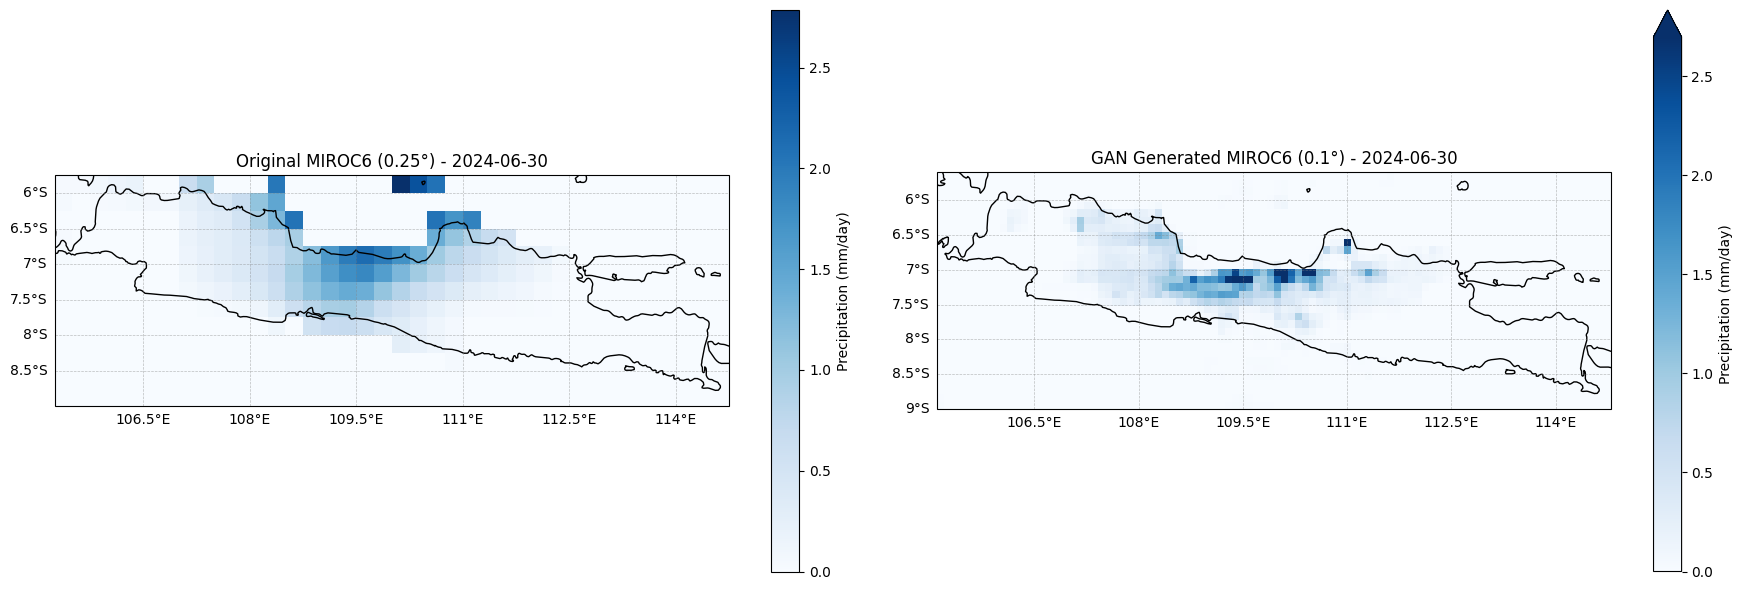

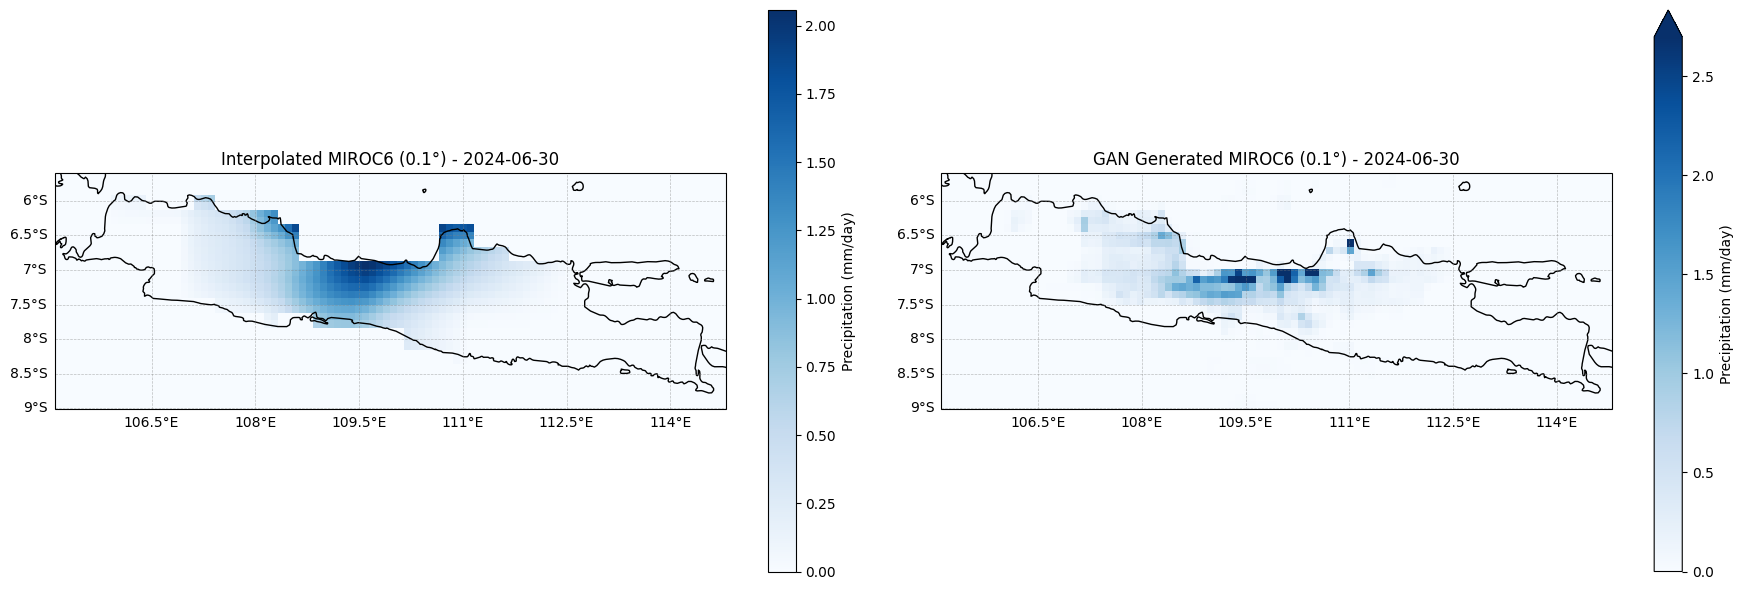

In [55]:
# Konversi data ke xarray DataArray untuk plotting yang lebih mudah
dsOriginalTest = image2Xarray(precipTestOriginal[..., 0], lonOriginal, latOriginal, timeOriginalTest)
dsGeneratedTest = image2Xarray(precipGeneratedTest[..., 0], lonHighRes, latHighRes, timeOriginalTest)

# Pilih tanggal spesifik (ganti dengan tanggal yang tersedia di dataset Anda)
specificDate = np.datetime64('2024-06-30')  # Sesuaikan dengan tanggal yang ada di dataset

# Ekstrak data presipitasi untuk tanggal tertentu
precipOriginal = selectPrecipitation(dsOriginalTest, specificDate)
precipGenerated = selectPrecipitation(dsGeneratedTest, specificDate)

# Buat plot perbandingan
fig, ax = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot data original
precipOriginal.plot(
    ax=ax[0], cmap='Blues', transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitation (mm/day)'}
)


ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0].set_title(f"Original MIROC6 (0.25°) - {specificDate}")

# Plot data hasil GAN
precipGenerated.plot(
    ax=ax[1], cmap='Blues', transform=ccrs.PlateCarree(), vmax=2.7,
    cbar_kwargs={'label': 'Precipitation (mm/day)'}
)
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1].set_title(f"GAN Generated MIROC6 (0.1°) - {specificDate}")

# Tambahkan gridlines
for a in ax:
    gl = a.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

# Simpan dan tampilkan plot
plt.tight_layout()
plt.savefig(f"{DatasetsFolder}/MIROC6_Original_vs_GAN_{specificDate}.png", dpi=300, bbox_inches='tight')
plt.show()



# Tambahan plot untuk original vs interpolasi
dsHighResTest = image2Xarray(precipHighResTest[..., 0], lonHighRes, latHighRes, timeOriginalTest)
precipHighRes = selectPrecipitation(dsHighResTest, specificDate)


# Buat plot perbandingan interpolasi vs GAN
fig3, ax3 = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot data interpolasi
precipHighRes.plot(
    ax=ax3[0], cmap='Blues', transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitation (mm/day)'}
)
ax3[0].coastlines()
ax3[0].add_feature(cfeature.BORDERS, linestyle=':')
ax3[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax3[0].set_title(f"Interpolated MIROC6 (0.1°) - {specificDate}")

# Plot data GAN
precipGenerated.plot(
    ax=ax3[1], cmap='Blues', transform=ccrs.PlateCarree(), vmax=2.7,
    cbar_kwargs={'label': 'Precipitation (mm/day)'}
)
ax3[1].coastlines()
ax3[1].add_feature(cfeature.BORDERS, linestyle=':')
ax3[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax3[1].set_title(f"GAN Generated MIROC6 (0.1°) - {specificDate}")

# Tambahkan gridlines
for a in ax3:
    gl = a.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

# Simpan dan tampilkan plot
plt.tight_layout()
plt.savefig(f"{DatasetsFolder}/MIROC6_Interpolated_vs_GAN_{specificDate}.png", dpi=300, bbox_inches='tight')
plt.show()